# Capstone Project - The Battle of Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

Tokyo is one of the world’s leading metropolises, attracting thousands of tourists every day. Meanwhile, with the 2020 Tokyo Olympics approaching, it is profitable for house owners to transform the houses that are available to **bed and breakfast**. 

When dealing with such problem, we should consider the **visitor flow rates** during the day and night as well as **surrounding facilities** like restaurants and subway line. Moreover, **house price** should also be taken into consideration during slack season.

In a nutshell, the issue is to find a suitable place with convenient facilities and relatively low estate price. Also, the accommodation places nearby should not already saturated.

Target Audience:
- People with several housing in Tokyo city and have the desire to earn money through bnb.
- Investor who want to set up an inn or run a chain hotel.
- Tourists from other cities or countries that want to find a good place to stay when traveling to Tokyo.

## 2. Data <a name="data"></a>

### 2.1 Web Scrapping

Considering most of the houses is prepared for tourists from other cities and countries who have a tendency to browse the main spots as many as possible, we only focused on Tokyo’s central 6 wards: **Bunkyo**, **Chiyoda**, **Chuo**, **Minato**, **Shibuya** and **Shinjuku**.

The web page [zip.nowmsg.com](https://zip.nowmsg.com/) contains the postal code of each district and its corresponding location. We used **BeautifulSoup** to scrap the page and get a table with four cloums: **Ward**, **District**, **Latitude** and **Longitude**.

Some of the places have different postal codes but share the same location. In such circumstance, I cleaned the data by only leaving a single line.


*Only a part of the web-scrapping code is shown below.*

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
response_obj = requests.get('https://zip.nowmsg.com/city.asp?country=JP&state=Tokyo%20To&county=Shinjuku%20Ku').text

In [ ]:
soup = BeautifulSoup(response_obj,'html.parser')

In [ ]:
lst = []
for row in soup.select('div[class="col-md-3 my-padding-6"]'):
    district = row.text.strip()
    url = 'https://zip.nowmsg.com/postal_code.asp?country=JP&state=Tokyo%20To&county=Shinjuku%20Ku&city='+district
    inside = requests.get(url).text
    s = BeautifulSoup(inside,'html.parser')
    s_list = s.select('table[class="table table-hover"]')
    tmp = str(s_list)
    patt = re.compile(r'\b\d+\.\d+')
    lnl = patt.findall(tmp)
    lat = lnl[0]
    lon = lnl[1]
    lst.append(['Shinjuku',district,lat,lon])


s_df = pd.DataFrame(lst, columns=["Ward", "District","Latitude","longitude"])

After reorganizing at local, the result is as below:

In [5]:
df_district = pd.read_excel('district.xlsx')
df_district

,Ward,District,Latitude,Longitude
0,Shinjuku,Agebacho,35.7024,139.7430
1,Shinjuku,Aizumicho,35.6902,139.7199
2,Shinjuku,Akagi Motomachi,35.7056,139.7393
3,Shinjuku,Akagi Shitamachi,35.7057,139.7343
4,Shinjuku,Arakicho,35.6902,139.7229
...,...,...,...,...
178,Minato,Shibadaimon,35.6542,139.7534
179,Minato,Shibakoen,35.6578,139.7476
180,Minato,Shirokane,35.6430,139.7269
181,Minato,Shirokanedai,35.6339,139.7297


In [6]:
import folium

In [7]:
latitude = 35.6804
longitude = 139.7690
print('The geograpical coordinate Tokyo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate Tokyo are 35.6804, 139.769.


Now, use folium to view it more directly.

In [8]:
map_6_ward = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, ward, district in zip(df_district['Latitude'], df_district['Longitude'], df_district['Ward'], df_district['District']):
    label = '{}, {}'.format(district, ward)
#     print(label)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_6_ward)
    
map_6_ward

### 2.2 House Price Data & Passenger Flow Data

* From the [report](https://www.mlit.go.jp/common/001080545.pdf) published by Japan Tourism Agency in 2014, we are able to view the tourists in each area during the day (6:00 ∼ 21:59) and night (22:00 ∼ 5:59) respectively. We sorted out the data manually.
* From [utinokati.com](https://utinokati.com/), we are able to get the information of house price in the 6 wards.

These two data help us make a more comprehensive decision.

After reorganizing at local, the result is as below:

In [11]:
df_2_2 = pd.read_excel('data_2_2.xlsx')
df_2_2

,Ward,Pop_day (people/hour),Pop_night (people/hour),Pop_ave (people/hour),Average Unit Price (JPY/sq.m)
0,Chiyoda,5099,4530,4909,1916817
1,Chuo,3703,4199,3868,3124750
2,Minato,8156,9868,8726,2322191
3,Shibuya,4060,3412,3844,1361241
4,Shinjuku,6312,8705,7109,932892
5,Bunkyō,1077,1201,1118,963145


### 2.3 Foursquare Data

Two groups of data is obtained using Foursquare API.
* Number of venues and their type and location around every neighborhood/district.
* Number of hotels around every neighborhood/district.

In [13]:
CLIENT_ID = 'FBRTSN1YMP0HEYRJOMOMC0P3TTOZPME50XDMIEQQRH5PA2IM'
CLIENT_SECRET = 'ODX200QGVCLGYHQCSBQ25MEVDXOK2J0W53UL4IKTDLGSRGP5'
VERSION = '20180605' # Foursquare API version

In [14]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name) 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

tokyo_venues = getNearbyVenues(names=df_district['District'],
                               latitudes=df_district['Latitude'],
                               longitudes=df_district['Longitude']
                              )

In [22]:
tokyo_venues = pd.read_excel('venue.xlsx') #in order not to make too many requests by Foursquare api

In [24]:
tokyo_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agebacho,35.7024,139.7430,Kinozen (紀の善),35.700595,139.742369,Wagashi Place
1,Agebacho,35.7024,139.7430,三州屋 飯田橋,35.703015,139.744219,Sake Bar
2,Agebacho,35.7024,139.7430,Kagurazaka Uokin (神楽坂魚金),35.702105,139.741621,Seafood Restaurant
3,Agebacho,35.7024,139.7430,Grilled Aging Beef (グリルド エイジング・ビーフ),35.701735,139.742386,Steakhouse
4,Agebacho,35.7024,139.7430,BEER BAR Bitter,35.702833,139.740863,Bar
...,...,...,...,...,...,...,...
13294,Takanawa,35.6321,139.7342,牛貴族 高輪道場,35.631684,139.730401,BBQ Joint
13295,Takanawa,35.6321,139.7342,由膳,35.631039,139.729786,Japanese Restaurant
13296,Takanawa,35.6321,139.7342,キャロル Carol,35.636063,139.733063,Tea Room
13297,Takanawa,35.6321,139.7342,メリーロード高輪,35.636353,139.733334,Shopping Mall


In [ ]:
def getNearbyVenues_hotel(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=hotel'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

tokyo_hotels = getNearbyVenues_hotel(names=df_hotel['District'],
                               latitudes=df_hotel['Latitude'],
                               longitudes=df_hotel['Longitude']
                              )

In [25]:
tokyo_hotels = pd.read_excel('hotel.xlsx') #in order not to make too many requests by Foursquare api

In [26]:
tokyo_hotels

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agebacho,35.7024,139.7430,The Agnes Hotel and Apartments Tokyo (アグネスホテルア...,35.699759,139.740770,Hotel
1,Agebacho,35.7024,139.7430,Flexstay Inn Iidabashi (フレックステイイン 飯田橋),35.705296,139.742290,Hotel
2,Agebacho,35.7024,139.7430,ヴィアイン飯田橋後楽園,35.705748,139.743540,Hotel
3,Agebacho,35.7024,139.7430,APA Hotel Iidabashi-ekimae (アパホテル 飯田橋駅前),35.701061,139.747734,Bed & Breakfast
4,Agebacho,35.7024,139.7430,Tokyo CENTRAL Youth Hostel (東京セントラルユースホステル),35.701014,139.742983,Hostel
...,...,...,...,...,...,...,...
1320,Takanawa,35.6321,139.7342,Miyako City Tokyo Takanawa (都シティ 東京高輪),35.633690,139.737785,Hotel
1321,Takanawa,35.6321,139.7342,ガーデンシティ品川,35.629383,139.736615,Hotel
1322,Takanawa,35.6321,139.7342,N Tower (Nタワー),35.628544,139.736364,Hotel
1323,Takanawa,35.6321,139.7342,グース,35.630046,139.737468,Bed & Breakfast


## 3. Methodology <a name="methodology"></a>

### In first step, we counted the number of hotels around each neighborhood in 500m.

**By comparing foreign tourists in each ward, we sifted out a bunch of neighborhoods around which the number of hotels is supposed to be saturated.**

In [29]:
hotel_count = tokyo_hotels.groupby(['Neighborhood'])['Neighborhood'].count().to_frame()

In [30]:
hotel_count.rename(columns={'Neighborhood':'Num_hotel'}, inplace=True)

In [31]:
hotel_count

,Num_hotel
Neighborhood,
Agebacho,5
Aizumicho,4
Akagi Motomachi,2
Akagi Shitamachi,1
Akasaka (Tsuginobiruonozoku),3
...,...
Yokoteramachi,1
Yotsuya,5
Yoyogi,4


In [36]:
pop_neigh = pd.read_excel('pop_neigh.xlsx')
a = pd.merge(pop_neigh,hotel_count,on='Neighborhood',how='outer') #outer ensures us to get the union instead of intersection
a=a.fillna(value=0) #turn NaN to 0
a['n'] = 1000*a['Num_hotel']/a['population']
a

,Ward,Neighborhood,population,Latitude,Longitude,Num_hotel,n
0,Shinjuku,Agebacho,7109,35.7024,139.7430,5.0,0.703334
1,Shinjuku,Aizumicho,7109,35.6902,139.7199,4.0,0.562667
2,Shinjuku,Akagi Motomachi,7109,35.7056,139.7393,2.0,0.281334
3,Shinjuku,Akagi Shitamachi,7109,35.7057,139.7343,1.0,0.140667
4,Shinjuku,Arakicho,7109,35.6902,139.7229,4.0,0.562667
...,...,...,...,...,...,...,...
178,Minato,Shibadaimon,8726,35.6542,139.7534,14.0,1.604401
179,Minato,Shibakoen,8726,35.6578,139.7476,11.0,1.260601
180,Minato,Shirokane,8726,35.6430,139.7269,3.0,0.343800
181,Minato,Shirokanedai,8726,35.6339,139.7297,3.0,0.343800


In [37]:
a = a.drop(a[a.n > 1].index)
a

,Ward,Neighborhood,population,Latitude,Longitude,Num_hotel,n
0,Shinjuku,Agebacho,7109,35.7024,139.7430,5.0,0.703334
1,Shinjuku,Aizumicho,7109,35.6902,139.7199,4.0,0.562667
2,Shinjuku,Akagi Motomachi,7109,35.7056,139.7393,2.0,0.281334
3,Shinjuku,Akagi Shitamachi,7109,35.7057,139.7343,1.0,0.140667
4,Shinjuku,Arakicho,7109,35.6902,139.7229,4.0,0.562667
...,...,...,...,...,...,...,...
174,Minato,Minamiaoyama,8726,35.6646,139.7155,4.0,0.458400
175,Minato,Motoazabu,8726,35.6565,139.7292,6.0,0.687600
177,Minato,Roppongi Izumigadentawa(1-Kai),8726,35.6588,139.7344,5.0,0.573000
180,Minato,Shirokane,8726,35.6430,139.7269,3.0,0.343800


**Up to now, we only left 104 Neighborhood/District with hotels nearby undersaturated**

### The second step is to analyze each neighborhood.

In [38]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

tokyo_onehot.head()

,Neighborhood,ATM,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo Exhibit
0,Agebacho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agebacho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agebacho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agebacho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agebacho,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
tokyo_onehot.shape

(13299, 350)

**Let's group rows by neighborhood by taking the mean of the frequency of occurrence of each category.**

In [40]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped

,Neighborhood,ATM,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo Exhibit
0,Agebacho,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.010000,0.000000,0.0,0.0,0.030000,0.0,0.000000,0.0,0.0
1,Aizumicho,0.012346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012346,0.000000,0.000000,0.0,0.0,0.012346,0.0,0.012346,0.0,0.0
2,Akagi Motomachi,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.011628,0.0,0.0,0.023256,0.0,0.000000,0.0,0.0
3,Akagi Shitamachi,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.014493,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,Akasaka (Tsuginobiruonozoku),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.014706,0.000000,0.0,0.0,0.014706,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Yokoteramachi,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.010000,0.0,0.0,0.010000,0.0,0.000000,0.0,0.0
178,Yotsuya,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.016129,0.0,0.0
179,Yoyogi,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
180,Yoyogikamizonocho,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


**Then, we only left the 104 neighborhood with under saturated hotels nearby.**

In [41]:
a = a.drop(['Ward','population','Num_hotel','n'], axis=1)
df = pd.merge(a,tokyo_grouped,on='Neighborhood')
df

,Neighborhood,Latitude,Longitude,ATM,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo Exhibit
0,Agebacho,35.7024,139.7430,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,...,0.000000,0.010000,0.000000,0.0,0.00,0.030000,0.0,0.000000,0.00,0.0
1,Aizumicho,35.6902,139.7199,0.012346,0.0,0.00,0.0,0.00,0.0,0.0,...,0.012346,0.000000,0.000000,0.0,0.00,0.012346,0.0,0.012346,0.00,0.0
2,Akagi Motomachi,35.7056,139.7393,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,...,0.000000,0.000000,0.011628,0.0,0.00,0.023256,0.0,0.000000,0.00,0.0
3,Akagi Shitamachi,35.7057,139.7343,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,...,0.000000,0.000000,0.014493,0.0,0.00,0.000000,0.0,0.000000,0.00,0.0
4,Arakicho,35.6902,139.7229,0.010000,0.0,0.00,0.0,0.00,0.0,0.0,...,0.010000,0.000000,0.000000,0.0,0.00,0.010000,0.0,0.010000,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Minamiaoyama,35.6646,139.7155,0.000000,0.0,0.02,0.0,0.00,0.0,0.0,...,0.010000,0.020000,0.000000,0.0,0.01,0.010000,0.0,0.000000,0.00,0.0
100,Motoazabu,35.6565,139.7292,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,...,0.000000,0.010417,0.010417,0.0,0.00,0.000000,0.0,0.000000,0.00,0.0
101,Roppongi Izumigadentawa(1-Kai),35.6588,139.7344,0.000000,0.0,0.00,0.0,0.01,0.0,0.0,...,0.000000,0.020000,0.010000,0.0,0.00,0.010000,0.0,0.000000,0.01,0.0
102,Shirokane,35.6430,139.7269,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.00,0.023256,0.0,0.000000,0.00,0.0


**We then write a function to sort the top 10 most common venues of each neighborhood in descending order.**

In [44]:
import numpy as np

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:] 
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**And then, put it into a dataframe.**

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df['Neighborhood']

for ind in np.arange(df.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agebacho,Italian Restaurant,Japanese Restaurant,French Restaurant,BBQ Joint,Sake Bar,Ramen Restaurant,Kaiseki Restaurant,Chinese Restaurant,Soba Restaurant,Yakitori Restaurant
1,Aizumicho,Sake Bar,Ramen Restaurant,Convenience Store,BBQ Joint,Café,Climbing Gym,Coffee Shop,Japanese Restaurant,Bar,Chinese Restaurant
2,Akagi Motomachi,Italian Restaurant,Japanese Restaurant,French Restaurant,Sake Bar,Convenience Store,Café,Bakery,BBQ Joint,Steakhouse,Unagi Restaurant
3,Akagi Shitamachi,Convenience Store,Italian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Dessert Shop,Café,Sake Bar,Indian Restaurant,Bar
4,Arakicho,Sake Bar,Convenience Store,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Café,Grocery Store,Bar,Rock Club,Climbing Gym


### In the third step, we use k-means, a machine learning method to cluster the neighborhood into several clusters.

**We first use the elbow method to determine the number of k.**

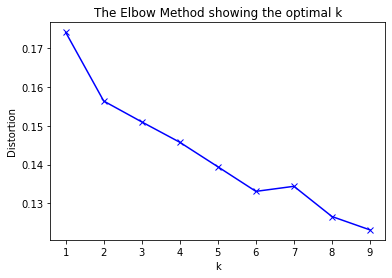

In [58]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(tokyo_grouped_clustering)
    kmeanModel.fit(tokyo_grouped_clustering)
    distortions.append(sum(np.min(cdist(tokyo_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tokyo_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


The optimal k is **2**

In [47]:
from sklearn.cluster import KMeans

In [71]:
# set number of clusters
kclusters = 2

tokyo_grouped_clustering = df.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], dtype=int32)

**Now, create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.**

In [76]:
# add clustering labels
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels',1)####
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = df[['Neighborhood','Latitude','Longitude']]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tokyo_merged.head(10) # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agebacho,35.7024,139.7430,0,Italian Restaurant,Japanese Restaurant,French Restaurant,BBQ Joint,Sake Bar,Ramen Restaurant,Kaiseki Restaurant,Chinese Restaurant,Soba Restaurant,Yakitori Restaurant
1,Aizumicho,35.6902,139.7199,0,Sake Bar,Ramen Restaurant,Convenience Store,BBQ Joint,Café,Climbing Gym,Coffee Shop,Japanese Restaurant,Bar,Chinese Restaurant
2,Akagi Motomachi,35.7056,139.7393,0,Italian Restaurant,Japanese Restaurant,French Restaurant,Sake Bar,Convenience Store,Café,Bakery,BBQ Joint,Steakhouse,Unagi Restaurant
3,Akagi Shitamachi,35.7057,139.7343,0,Convenience Store,Italian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Dessert Shop,Café,Sake Bar,Indian Restaurant,Bar
4,Arakicho,35.6902,139.7229,0,Sake Bar,Convenience Store,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Café,Grocery Store,Bar,Rock Club,Climbing Gym
5,Babashitacho,35.7060,139.7191,0,Ramen Restaurant,Japanese Restaurant,Convenience Store,Café,Yoshoku Restaurant,Bath House,Yakitori Restaurant,Grocery Store,Donburi Restaurant,Park
6,Bentencho,35.7033,139.7261,1,Convenience Store,Japanese Restaurant,ATM,Café,Donburi Restaurant,Ramen Restaurant,Soba Restaurant,Sake Bar,Supermarket,Italian Restaurant
7,Daikyocho,35.6850,139.7169,0,Intersection,Convenience Store,Japanese Restaurant,Café,Art Gallery,Museum,Indian Restaurant,Garden,Bus Stop,Sake Bar
8,Enokicho,35.7053,139.7288,1,Convenience Store,Ramen Restaurant,Chinese Restaurant,ATM,Photography Studio,Soba Restaurant,Grocery Store,Burger Joint,Rock Club,Park
9,Fukuromachi,35.7007,139.7407,0,Italian Restaurant,Japanese Restaurant,French Restaurant,BBQ Joint,Sake Bar,Steakhouse,Ramen Restaurant,Yakitori Restaurant,Chinese Restaurant,Coffee Shop


**Finally, visualize the resulting clusters.**

In [77]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [78]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['Neighborhood'], tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.4).add_to(map_clusters)
       
map_clusters

## 4. Analysis <a name="analysis"></a>

Examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [79]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 0, tokyo_merged.columns[[0] + list(range(4, tokyo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agebacho,Italian Restaurant,Japanese Restaurant,French Restaurant,BBQ Joint,Sake Bar,Ramen Restaurant,Kaiseki Restaurant,Chinese Restaurant,Soba Restaurant,Yakitori Restaurant
1,Aizumicho,Sake Bar,Ramen Restaurant,Convenience Store,BBQ Joint,Café,Climbing Gym,Coffee Shop,Japanese Restaurant,Bar,Chinese Restaurant
2,Akagi Motomachi,Italian Restaurant,Japanese Restaurant,French Restaurant,Sake Bar,Convenience Store,Café,Bakery,BBQ Joint,Steakhouse,Unagi Restaurant
3,Akagi Shitamachi,Convenience Store,Italian Restaurant,Japanese Restaurant,Bakery,Chinese Restaurant,Dessert Shop,Café,Sake Bar,Indian Restaurant,Bar
4,Arakicho,Sake Bar,Convenience Store,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Café,Grocery Store,Bar,Rock Club,Climbing Gym
...,...,...,...,...,...,...,...,...,...,...,...
98,Kitaaoyama,Baseball Stadium,Convenience Store,Ramen Restaurant,Coffee Shop,Sporting Goods Shop,Italian Restaurant,Chinese Restaurant,Spanish Restaurant,French Restaurant,Bike Rental / Bike Share
99,Minamiaoyama,Boutique,Café,Japanese Restaurant,Clothing Store,Coffee Shop,Dessert Shop,Tea Room,Steakhouse,Soba Restaurant,French Restaurant
100,Motoazabu,Japanese Restaurant,French Restaurant,Italian Restaurant,Soba Restaurant,BBQ Joint,Bakery,Coffee Shop,Sushi Restaurant,Chinese Restaurant,Steakhouse
101,Roppongi Izumigadentawa(1-Kai),Japanese Restaurant,BBQ Joint,Bakery,Chinese Restaurant,French Restaurant,Beer Bar,Udon Restaurant,Asian Restaurant,Soba Restaurant,Thai Restaurant


In [80]:
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 1, tokyo_merged.columns[[0] + list(range(4, tokyo_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bentencho,Convenience Store,Japanese Restaurant,ATM,Café,Donburi Restaurant,Ramen Restaurant,Soba Restaurant,Sake Bar,Supermarket,Italian Restaurant
8,Enokicho,Convenience Store,Ramen Restaurant,Chinese Restaurant,ATM,Photography Studio,Soba Restaurant,Grocery Store,Burger Joint,Rock Club,Park
12,Haramachi,Convenience Store,Japanese Restaurant,Coffee Shop,ATM,Sake Bar,Italian Restaurant,Pharmacy,Soba Restaurant,Supermarket,Camera Store
13,Higashienokicho,Convenience Store,Chinese Restaurant,Sake Bar,Soba Restaurant,Italian Restaurant,Bakery,Ramen Restaurant,Bookstore,Café,Japanese Restaurant
16,Ichigayadaimachi,Convenience Store,Ramen Restaurant,Grocery Store,Steakhouse,Dessert Shop,Hotel,Japanese Curry Restaurant,BBQ Joint,Climbing Gym,Supermarket
17,Ichigayakagacho,Convenience Store,Italian Restaurant,French Restaurant,Grocery Store,ATM,Coffee Shop,Drugstore,BBQ Joint,Shanghai Restaurant,Breakfast Spot
18,Ichigayakoracho,Convenience Store,ATM,Ramen Restaurant,Sake Bar,French Restaurant,Italian Restaurant,Drugstore,Chinese Restaurant,Seafood Restaurant,Beer Bar
21,Kamiochiai,Convenience Store,Ramen Restaurant,Sake Bar,Drugstore,Grocery Store,Train Station,Donburi Restaurant,Coffee Shop,Dry Cleaner,Chinese Restaurant
22,Kasumigaokamachi,Convenience Store,Sake Bar,Chinese Restaurant,Café,Japanese Restaurant,BBQ Joint,Intersection,Grocery Store,Museum,Ramen Restaurant
23,Kawadacho,Convenience Store,Coffee Shop,Supermarket,ATM,Fast Food Restaurant,Spanish Restaurant,Grocery Store,Martial Arts Dojo,Arts & Crafts Store,Tempura Restaurant


And then we have a roughly view on the rental price of every ward. Areas with lower rent is more suitable to be built as bed and breakfast. 

For people who want to decide whether to change a house he have already owned, rental price can help him to weigh the advantages and disadvantages with renting out his house to local people, because during slack seasons, homes without tenant can become a loss.

For people who want to invest in this field (buy a new house), rental price can also reflect the house price of each place.

In [88]:
df_price = pd.read_excel('data_rent.xlsx')
df_price

,Ward,Average Unit Rental
0,千代田区,4158
1,中央区,3842
2,港区,4474
3,渋谷区,4306
4,新宿区,3900
5,文京区,3636


In [89]:
lnd_geo = r'tokyo.geojson'
lnd_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

lnd_map.choropleth(
    geo_data=lnd_geo,
    data=df_price,
    columns=['Ward','Average Unit Rental'],
    key_on='feature.properties.ward_ja',
    fill_color='PuRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster Labels'
)

lnd_map

/Users/wenyema/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## 5. Results <a name="results"></a>

We combine the choropleth map with the clusters.

In [90]:
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['Neighborhood'], tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.4).add_to(lnd_map)
       
lnd_map

## 6. Discussion <a name="discussion"></a>

While western restaurants, bars and Café is common as the 1st most common venues of cluster 0, all of the cluster 1 neighborhoods' 1st common venue is **convenience store** (except 1 bus store).

Undoubtedly, for most of the tourists who go out early and get home late at night (in order to visit places as many as possible), convenience store is an ideal place for them to pick up food and have on the road. (While Italian restaurants, gyms and baseball stadiums are generally for natives.）

Considering the high rent in other wards, purple points (cluster 1) located in Shinjuku and Bunkyo can be sensible choices to set up a bed and breakfast.

To be more specific, we collected the data of 40 neighborhoods in cluster 1. (Unable to find other 3 neighborhoods' data).

We also excluded Toyomicho because it is 20 min away from the nearest subway station, which is not suitable for tourists.

In [114]:
import seaborn as sns

In [183]:
df_result = pd.read_excel('result.xlsx')

In [184]:
df_result.head()

,Neighborhood,rent
0,Bentencho,3795
1,Enokicho,3945
2,Haramachi,3724
3,Higashienokicho,3543
4,Kamiochiai,3307


Text(0.5, 1.0, 'Average Rent in Each Neighborhood (yen/m²)')

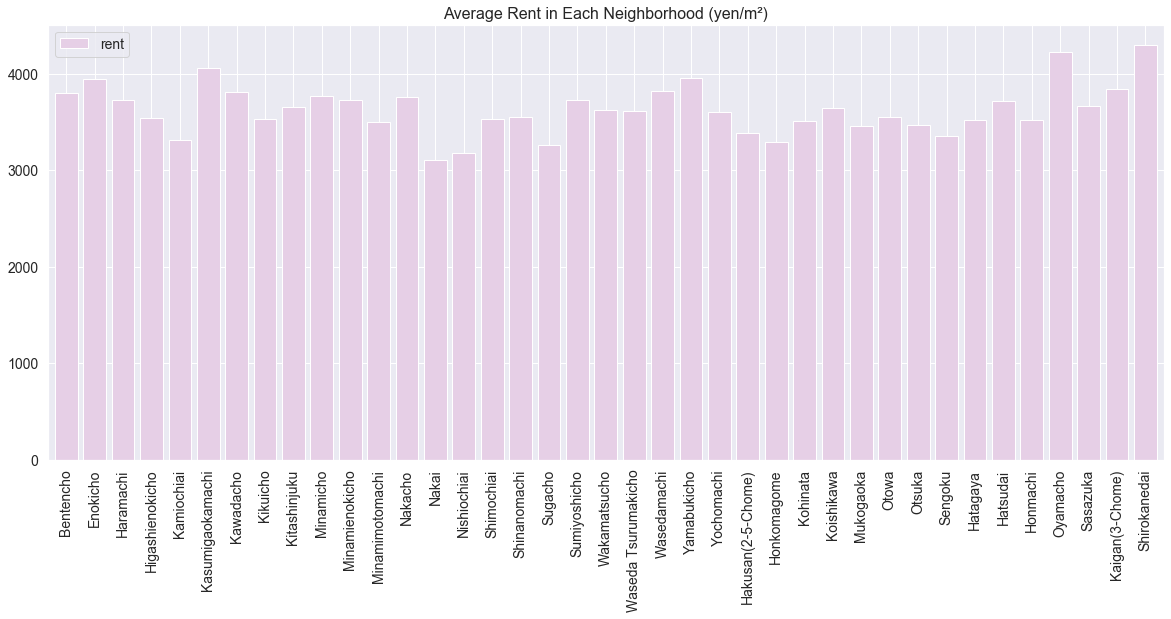

In [174]:
color_list = ['#e6cfe6']
a = df_result.plot.bar(figsize = (20,8),width = 0.8,color = color_list)
a.legend(fontsize=14)
a.tick_params(labelsize=14)
a.set_title('Average Rent in Each Neighborhood (yen/m²)',fontsize=16)

In [187]:
tokyo_result = tokyo_merged[tokyo_merged['Cluster Labels'] == 1]
tokyo_result = tokyo_result[['Neighborhood','Latitude','Longitude']]
tokyo_result = pd.merge(tokyo_result,df_result,on='Neighborhood')
tokyo_result.head()

,Neighborhood,Latitude,Longitude,rent
0,Bentencho,35.7033,139.7261,3795
1,Enokicho,35.7053,139.7288,3945
2,Haramachi,35.7012,139.7226,3724
3,Higashienokicho,35.7057,139.7309,3543
4,Kamiochiai,35.7130,139.6876,3307


In [224]:
map_results = folium.Map(location=[latitude, longitude], zoom_start=12)

In [225]:
for lat, lon, neigh, rt in zip(tokyo_result['Latitude'], tokyo_result['Longitude'], tokyo_result['Neighborhood'], tokyo_result['rent']):
    label = folium.Popup(str(neigh)  + '-' + str(rt)+ '¥', parse_html=True)
    if (rt<3250):
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='#ffccd5',
            fill=True,
            fill_color='#ffccd5',
            fill_opacity=0.5).add_to(map_results)
    elif (3500>rt>=3250):
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='#ff6680',
            fill=True,
            fill_color='#ff6680',
            fill_opacity=0.5).add_to(map_results)
    elif (3750>rt>=3500):
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='#ff002b',
            fill=True,
            fill_color='#ff002b',
            fill_opacity=0.5).add_to(map_results)
    elif (4000>rt>=3750):
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='#99001a',
            fill=True,
            fill_color='#99001a',
            fill_opacity=0.5).add_to(map_results)
    else:
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='#330009',
            fill=True,
            fill_color='#330009',
            fill_opacity=0.5).add_to(map_results)

map_results

## 7. Conclusion <a name="conclusion"></a>

In general, Shinjuku and Bunkyo are the most suitable places to set bed and breakfasts since they have a lot of neighborhoods with convenient facilities and relatively low rent cost.

There is no absolute optimal place to set the bed and breakfast, but we indeed can conbine the location and the rent price to consider using the map_results about. (For example, Sugacho is a pretty good place with cheap rent and the location near the center of city)

Of course, there are still some disadvantages through our analyze, like we didn't consider whether the subway line nearby is just a normal station or a large station.

To improve, we can also use other machine learning methods like DBSCAN to get a more precise result.